In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!pip install 'h5py<3.0.0'
!pip install sklearn_crfsuite
# !pip install tensorflow==1.15.2 keras==2.3.1
!pip3 install glove-python-binary
!pip install git+https://www.github.com/keras-team/keras-contrib.git --upgrade
!pip install catboost

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-oo0bniej
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-oo0bniej
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=2631ed9af3a15cf80b48bc02dd5cbae95dc69e9d535d17bc3a145ebec3dce56c
  Stored in directory: /tmp/pip-ephem-wheel-cache-k1zbx6oe/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
  Found existing installation: keras-contrib 2.0.8
    Uninstalling keras-contrib-2.0.8:
      Successfully uninstalled keras-contrib-2.0.8


In [3]:
!gdown --id 1L6dd0FnYqgn-eoQ-gFnBiNji7R1ul9n_
!gdown --id 1-5mE9XjocmyCKGlkpW1YGuCnNsGwQioD
!gdown --id 1d4er4I7x4VIwy7BsWFpsPuC2z6aZ3P6s

Downloading...
From: https://drive.google.com/uc?id=1L6dd0FnYqgn-eoQ-gFnBiNji7R1ul9n_
To: /content/NER_RFQ_agg.csv
4.39MB [00:00, 142MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-5mE9XjocmyCKGlkpW1YGuCnNsGwQioD
To: /content/NER_RFQ_agg_train.csv
3.48MB [00:00, 109MB/s]
Downloading...
From: https://drive.google.com/uc?id=1d4er4I7x4VIwy7BsWFpsPuC2z6aZ3P6s
To: /content/NER_RFQ_agg_test.csv
100% 909k/909k [00:00<00:00, 60.6MB/s]


In [3]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from nltk.corpus import stopwords
import pandas as pd
import pickle
import re
import datetime
import os
import numpy as np

from keras.optimizers import Adam
from keras.models import *
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy, crf_marginal_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

import gensim.downloader as api
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from gensim.models import Word2Vec
from glove import Corpus, Glove
from tqdm import tqdm

Using TensorFlow backend.


In [4]:
df = pd.read_csv('NER_RFQ_agg.csv', converters={'tokens': eval, 'ner_tags': eval})
train = pd.read_csv('NER_RFQ_agg_train.csv', converters={'tokens': eval, 'ner_tags': eval})
test = pd.read_csv('NER_RFQ_agg_test.csv', converters={'tokens': eval, 'ner_tags': eval})

all_dfs = [df, train, test]

In [5]:
def find_token(x):
    SUFFIXES = ['_DET', '_NOUN', '_VERB', '_ADJ', '']
    res = []
    for w in x['tokens']:
        has_found = False
        for suffix in SUFFIXES:
            if w + suffix in w2v.wv.vocab.keys():
                res.append(w2v.wv.vocab[w + suffix].index)
                has_found = True
                break
        if not has_found:
            res.append(0)
    return res

all_tags = set()
for _, row in df.iterrows():
    for tag in row.ner_tags:
        all_tags.add(tag)
all_tags = sorted(list(all_tags))
tag_to_idx = {t: i for i, t in enumerate(all_tags)}
label_list = {i: t for i, t in enumerate(all_tags)}
labels = list(tag_to_idx.keys())
labels.remove('O')
labels = sorted(labels, key=lambda name: (name[1:], name[0]))
for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)

In [ ]:
pretrained_w2v = api.load("word2vec-ruscorpora-300")
pretrained_w2v.save_word2vec_format('tmp')

In [ ]:
def add_suffix(x):
    SUFFIXES = ['_DET', '_NOUN', '_VERB', '_ADJ']
    res = []
    for w in x['tokens']:
        has_found = False
        for suffix in SUFFIXES:
            if w + suffix in pretrained_w2v.vocab.keys():
                res.append(w + suffix)
                has_found = True
                break
        if not has_found:
            res.append(w)
    return res

for d in all_dfs:
    d['tokens_with_suffix'] = d.apply(add_suffix, axis=1)

In [ ]:
w2v = Word2Vec(sentences=df['tokens_with_suffix'], size=300, window=5, min_count=2)
w2v.train(sentences=df['tokens'], total_examples=w2v.corpus_count, epochs=30)

In [ ]:
w2v.intersect_word2vec_format('tmp')

In [ ]:
for d in all_dfs:
    d['int_tokens'] = d.apply(find_token, axis=1)

In [ ]:
df

,id,tokens,ner_tags,tokens_with_suffix,encoded_ner_tags,int_tokens
0,119287R.msg,"[name, 119287r.msg, <aogdesk@nordstar.ru>, <mv...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[name_NOUN, 119287r.msg, <aogdesk@nordstar.ru>...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[19, 0, 206, 744, 293, 22, 190, 0, 30, 36, 237..."
1,119735R.msg,"[name, 119735r.msg, <aogdesk@nordstar.ru>, <mv...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[name_NOUN, 119735r.msg, <aogdesk@nordstar.ru>...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[19, 0, 206, 744, 293, 22, 190, 6707, 624, 106..."
2,120421R.msg,"[name, 120421r.msg, d.klebcha@s7.ru, <d.klebch...","[O, O, O, O, O, O, O, O, B-GoodsString, I-Good...","[name_NOUN, 120421r.msg, d.klebcha@s7.ru, <d.k...","[2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, ...","[19, 0, 5524, 5525, 5526, 2961, 22, 57, 874, 2..."
3,120660R.msg,"[name, 120660r.msg, yuliya, a., kondratova, <y...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[name_NOUN, 120660r.msg, yuliya, a., kondratov...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[19, 5530, 846, 833, 518, 847, 12, 22, 57, 255..."
4,120660R.msg,"[name, 120660r.msg, yuliya, a., kondratova, <y...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[name_NOUN, 120660r.msg, yuliya, a., kondratov...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[19, 5530, 846, 833, 518, 847, 12, 22, 57, 255..."
...,...,...,...,...,...,...
1187,123527R.msg,"[name, 123527r.msg, =?utf-8?b?0kprincw0lrqvtcy...","[O, O, O, O, O, O, O, O, B-GoodsString, O, O, ...","[name_NOUN, 123527r.msg, =?utf-8?b?0kprincw0lr...","[2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, ...","[19, 0, 1249, 1250, 1251, 12, 22, 679, 0, 1026..."
1188,123088R.msg,"[name, 123088r.msg, lakshmi, suresh, <lakshmi@...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[name_NOUN, 123088r.msg, lakshmi, suresh, <lak...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[19, 6241, 4264, 4265, 6242, 2961, 22, 147, 62..."
1189,123508R.msg,"[name, 123508r.msg, <aogdesk@nordstar.ru>, <mv...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[name_NOUN, 123508r.msg, <aogdesk@nordstar.ru>...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[19, 7935, 206, 744, 293, 22, 190, 7936, 30, 3..."
1190,124894R.msg,"[name, 124894r.msg, <anton.peshko@utair.ru>, a...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[name_NOUN, 124894r.msg, <anton.peshko@utair.r...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[19, 0, 304, 47, 305, 304, 22, 115, 5523, 278,..."


In [12]:
import warnings

warnings.filterwarnings("ignore")

In [9]:
def focal_loss(gamma=2., alpha=1.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {1.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

## PRETRAINED W2V(not fixed) + BILSTM + CRF

In [ ]:
MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 100

model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=True))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model.add(crf)

model.compile(Adam(lr=0.01), loss=focal_loss(), metrics=[crf_marginal_accuracy])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3004, 300)         2544900   
_________________________________________________________________
bidirectional (Bidirectional (None, 3004, 200)         320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 3004, 3)           603       
_________________________________________________________________
crf (CRF)                    (None, 3004, 3)           27        
Total params: 2,866,330
Trainable params: 2,866,330
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='pretrained_best_model.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=128,
    callbacks=callbacks,
    validation_split=0.1,
)

model.load_weights('pretrained_best_model.h5')


Train on 857 samples, validate on 96 samples
Epoch 1/30
857/857 [==============================] - 66s 77ms/step - loss: 0.4820 - crf_marginal_accuracy: 0.7108 - val_loss: 0.4655 - val_crf_marginal_accuracy: 0.9684
Epoch 2/30
857/857 [==============================] - 64s 74ms/step - loss: 0.4570 - crf_marginal_accuracy: 0.9915 - val_loss: 0.4606 - val_crf_marginal_accuracy: 0.9699
Epoch 3/30
857/857 [==============================] - 63s 74ms/step - loss: 0.4507 - crf_marginal_accuracy: 0.9738 - val_loss: 0.4561 - val_crf_marginal_accuracy: 0.9960
Epoch 4/30
857/857 [==============================] - 63s 74ms/step - loss: 0.4438 - crf_marginal_accuracy: 0.9965 - val_loss: 0.4492 - val_crf_marginal_accuracy: 0.9960
Epoch 5/30
857/857 [==============================] - 64s 75ms/step - loss: 0.4209 - crf_marginal_accuracy: 0.9947 - val_loss: 0.4205 - val_crf_marginal_accuracy: 0.9878
Epoch 6/30
857/857 [==============================] - 63s 74ms/step - loss: 0.3621 - crf_marginal_accura

AttributeError: ignored

In [ ]:
preds = model.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.9294    0.8548    0.8906      1109
I-GoodsString     0.9505    0.8166    0.8785      1718

    micro avg     0.9419    0.8316    0.8833      2827
    macro avg     0.9400    0.8357    0.8845      2827
 weighted avg     0.9423    0.8316    0.8832      2827



## PRETRAINED W2V(fixed) + BILSTM + CRF

In [17]:
MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 50

model_fixed_embeds = Sequential()
model_fixed_embeds.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=False))
model_fixed_embeds.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model_fixed_embeds.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model_fixed_embeds.add(crf)

model_fixed_embeds.compile(Adam(lr=0.005), loss=focal_loss(alpha=4), metrics=[crf_marginal_accuracy])
model_fixed_embeds.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3004, 300)         2544900   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 3004, 100)         140400    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3004, 3)           303       
_________________________________________________________________
crf_2 (CRF)                  (None, 3004, 3)           27        
Total params: 2,685,630
Trainable params: 140,730
Non-trainable params: 2,544,900
_________________________________________________________________


In [18]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='pretrained_best_model_fixed_embeds.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model_fixed_embeds.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=128,
    callbacks=callbacks,
    validation_split=0.1,
)

model_fixed_embeds.load_weights('pretrained_best_model_fixed_embeds.h5')

Train on 857 samples, validate on 96 samples
Epoch 1/30
857/857 [==============================] - 61s 71ms/step - loss: 2.8965 - crf_marginal_accuracy: 0.0021 - val_loss: 2.4423 - val_crf_marginal_accuracy: 0.0023
Epoch 2/30
857/857 [==============================] - 60s 70ms/step - loss: 2.0859 - crf_marginal_accuracy: 0.2775 - val_loss: 1.9679 - val_crf_marginal_accuracy: 0.9443
Epoch 3/30
857/857 [==============================] - 60s 70ms/step - loss: 1.8852 - crf_marginal_accuracy: 0.9659 - val_loss: 1.8872 - val_crf_marginal_accuracy: 0.9786
Epoch 4/30
857/857 [==============================] - 60s 70ms/step - loss: 1.8381 - crf_marginal_accuracy: 0.9926 - val_loss: 1.8552 - val_crf_marginal_accuracy: 0.9948
Epoch 5/30
857/857 [==============================] - 60s 70ms/step - loss: 1.8215 - crf_marginal_accuracy: 0.9944 - val_loss: 1.8512 - val_crf_marginal_accuracy: 0.9931
Epoch 6/30
857/857 [==============================] - 60s 70ms/step - loss: 1.8171 - crf_marginal_accurac

In [19]:
preds = model_fixed_embeds.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.4027    0.5861    0.4774      1109
I-GoodsString     0.0000    0.0000    0.0000      1718

    micro avg     0.3930    0.2299    0.2901      2827
    macro avg     0.2014    0.2931    0.2387      2827
 weighted avg     0.1580    0.2299    0.1873      2827



## W2V(not fixed, window=5, min_count=2) + BILSTM + CRF

In [7]:
w2v = Word2Vec(sentences=df['tokens'], size=50, window=5, min_count=2)
w2v.train(sentences=df['tokens'], total_examples=w2v.corpus_count, epochs=30)
for d in all_dfs:
    d['int_tokens'] = d.apply(find_token, axis=1)

In [ ]:
MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 50

model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=True))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model.add(crf)

model.compile(Adam(lr=0.01), loss=focal_loss(), metrics=[crf_marginal_accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 3004, 300)         2544900   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 3004, 100)         140400    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 3004, 3)           303       
_________________________________________________________________
crf_11 (CRF)                 (None, 3004, 3)           27        
Total params: 2,685,630
Trainable params: 2,685,630
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='not_pretrained_best_model.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=128,
    callbacks=callbacks,
    validation_split=0.1,
)

model.load_weights('not_pretrained_best_model.h5')

Train on 857 samples, validate on 96 samples
Epoch 1/30
857/857 [==============================] - 98s 114ms/step - loss: 0.4957 - crf_marginal_accuracy: 0.6872 - val_loss: 0.4646 - val_crf_marginal_accuracy: 0.9956
Epoch 2/30
857/857 [==============================] - 92s 107ms/step - loss: 0.4535 - crf_marginal_accuracy: 0.4771 - val_loss: 0.4569 - val_crf_marginal_accuracy: 0.0709
Epoch 3/30
857/857 [==============================] - 91s 107ms/step - loss: 0.4468 - crf_marginal_accuracy: 0.8567 - val_loss: 0.4542 - val_crf_marginal_accuracy: 0.9965
Epoch 4/30
857/857 [==============================] - 91s 107ms/step - loss: 0.4386 - crf_marginal_accuracy: 0.9969 - val_loss: 0.4468 - val_crf_marginal_accuracy: 0.9960
Epoch 5/30
857/857 [==============================] - 91s 106ms/step - loss: 0.4189 - crf_marginal_accuracy: 0.9970 - val_loss: 0.4338 - val_crf_marginal_accuracy: 0.9970
Epoch 6/30
857/857 [==============================] - 91s 106ms/step - loss: 0.3850 - crf_marginal_a

In [ ]:
preds = model.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.9026    0.8602    0.8809      1109
I-GoodsString     0.8842    0.8487    0.8661      1718

    micro avg     0.8914    0.8532    0.8719      2827
    macro avg     0.8934    0.8544    0.8735      2827
 weighted avg     0.8914    0.8532    0.8719      2827



## W2V(fixed, window=5, min_count=2) + BILSTM + CRF

In [29]:
MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 50

model_fixed_embeds = Sequential()
model_fixed_embeds.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=False))
model_fixed_embeds.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model_fixed_embeds.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model_fixed_embeds.add(crf)

model_fixed_embeds.compile(Adam(lr=0.01), loss=focal_loss(alpha=4), metrics=[crf_marginal_accuracy])
model_fixed_embeds.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 3004, 50)          424150    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 3004, 100)         40400     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 3004, 3)           303       
_________________________________________________________________
crf_7 (CRF)                  (None, 3004, 3)           27        
Total params: 464,880
Trainable params: 40,730
Non-trainable params: 424,150
_________________________________________________________________


In [30]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='not_pretrained_best_model_fixed_embeds.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model_fixed_embeds.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=1024,
    callbacks=callbacks,
    validation_split=0.1,
)

model_fixed_embeds.load_weights('not_pretrained_best_model_fixed_embeds.h5')

Train on 857 samples, validate on 96 samples
Epoch 1/30
857/857 [==============================] - 14s 17ms/step - loss: 3.7022 - crf_marginal_accuracy: 0.0013 - val_loss: 4.7602 - val_crf_marginal_accuracy: 0.0021
Epoch 2/30
857/857 [==============================] - 13s 15ms/step - loss: 4.6038 - crf_marginal_accuracy: 0.0018 - val_loss: 3.2985 - val_crf_marginal_accuracy: 0.0014
Epoch 3/30
857/857 [==============================] - 13s 15ms/step - loss: 3.2380 - crf_marginal_accuracy: 0.0013 - val_loss: 3.1270 - val_crf_marginal_accuracy: 0.0014
Epoch 4/30
857/857 [==============================] - 13s 15ms/step - loss: 3.0572 - crf_marginal_accuracy: 0.0013 - val_loss: 2.7264 - val_crf_marginal_accuracy: 0.0014
Epoch 5/30
857/857 [==============================] - 13s 15ms/step - loss: 2.6721 - crf_marginal_accuracy: 0.0013 - val_loss: 2.3031 - val_crf_marginal_accuracy: 0.0015
Epoch 6/30
857/857 [==============================] - 13s 15ms/step - loss: 2.2782 - crf_marginal_accurac

In [31]:
preds = model_fixed_embeds.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.4673    0.1289    0.2021      1109
I-GoodsString     0.0000    0.0000    0.0000      1718

    micro avg     0.4673    0.0506    0.0913      2827
    macro avg     0.2337    0.0645    0.1011      2827
 weighted avg     0.1833    0.0506    0.0793      2827




## W2V(fixed, window=5, min_count=2) + CatBoost

In [8]:
EMBEDDING_LENGTH = w2v.vector_size
WINDOW_SIZE = 5
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(w2v.wv.vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])


train.apply(prepare_data_for_catboost, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
948    None
949    None
950    None
951    None
952    None
Length: 953, dtype: object

In [9]:
EMBEDDING_LENGTH = w2v.vector_size
WINDOW_SIZE = 5
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(w2v.wv.vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
234    None
235    None
236    None
237    None
238    None
Length: 239, dtype: object

In [11]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", class_weights=[1, 1, 0.3], iterations=1000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [12]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.8753    0.8990    0.8870      1109
I-GoodsString     0.8444    0.8749    0.8593      1718

    micro avg     0.8565    0.8843    0.8702      2827
    macro avg     0.8599    0.8869    0.8732      2827
 weighted avg     0.8565    0.8843    0.8702      2827



## W2V(not fixed, window=5, min_count=1) + BILSTM + CRF

In [22]:
w2v = Word2Vec(sentences=df['tokens'], size=50, window=5, min_count=1)
w2v.train(sentences=df['tokens'], total_examples=w2v.corpus_count, epochs=30)
for d in all_dfs:
    d['int_tokens'] = d.apply(find_token, axis=1)

In [34]:
MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 50

model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=True))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model.add(crf)

model.compile(Adam(lr=0.01), loss=focal_loss(), metrics=[crf_marginal_accuracy])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 3004, 50)          618050    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 3004, 100)         40400     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 3004, 3)           303       
_________________________________________________________________
crf_10 (CRF)                 (None, 3004, 3)           27        
Total params: 658,780
Trainable params: 658,780
Non-trainable params: 0
_________________________________________________________________


In [35]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='window=5,min_count=1,best_model.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=1024,
    callbacks=callbacks,
    validation_split=0.1,
)

model.load_weights('window=5,min_count=1,best_model.h5')

Train on 857 samples, validate on 96 samples
Epoch 1/30
857/857 [==============================] - 15s 18ms/step - loss: 0.9747 - crf_marginal_accuracy: 0.9966 - val_loss: 0.9106 - val_crf_marginal_accuracy: 0.9962
Epoch 2/30
857/857 [==============================] - 13s 15ms/step - loss: 0.8899 - crf_marginal_accuracy: 0.9966 - val_loss: 0.8760 - val_crf_marginal_accuracy: 0.9962
Epoch 3/30
857/857 [==============================] - 13s 15ms/step - loss: 0.8530 - crf_marginal_accuracy: 0.9966 - val_loss: 0.8516 - val_crf_marginal_accuracy: 0.9963
Epoch 4/30
857/857 [==============================] - 13s 15ms/step - loss: 0.8271 - crf_marginal_accuracy: 0.9966 - val_loss: 0.8217 - val_crf_marginal_accuracy: 0.9962
Epoch 5/30
857/857 [==============================] - 13s 15ms/step - loss: 0.7966 - crf_marginal_accuracy: 0.9966 - val_loss: 0.7970 - val_crf_marginal_accuracy: 0.9962
Epoch 6/30
857/857 [==============================] - 13s 15ms/step - loss: 0.7708 - crf_marginal_accurac

In [29]:
preds = model.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.5954    0.6276    0.6111      1109
I-GoodsString     0.7830    0.1932    0.3100      1718

    micro avg     0.6453    0.3636    0.4652      2827
    macro avg     0.6892    0.4104    0.4605      2827
 weighted avg     0.7094    0.3636    0.4281      2827



## W2V(fixed, window=5, min_count=1) + BILSTM + CRF

In [40]:
MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 50

model_fixed_embeds = Sequential()
model_fixed_embeds.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=False))
model_fixed_embeds.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model_fixed_embeds.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model_fixed_embeds.add(crf)

model_fixed_embeds.compile(Adam(lr=0.01), loss=focal_loss(gamma=5), metrics=[crf_marginal_accuracy])
model_fixed_embeds.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 3004, 50)          618050    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 3004, 100)         40400     
_________________________________________________________________
time_distributed_13 (TimeDis (None, 3004, 3)           303       
_________________________________________________________________
crf_13 (CRF)                 (None, 3004, 3)           27        
Total params: 658,780
Trainable params: 40,730
Non-trainable params: 618,050
_________________________________________________________________


In [42]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=10),
         ModelCheckpoint(filepath='window=5,min_count=1,best_model_fixed_embeds.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model_fixed_embeds.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=1024,
    callbacks=callbacks,
    validation_split=0.1,
)

model_fixed_embeds.load_weights('window=5,min_count=1,best_model_fixed_embeds.h5')

Train on 857 samples, validate on 96 samples
Epoch 1/30
857/857 [==============================] - 13s 15ms/step - loss: 0.2429 - crf_marginal_accuracy: 0.9960 - val_loss: 0.1958 - val_crf_marginal_accuracy: 0.9966
Epoch 2/30
857/857 [==============================] - 13s 15ms/step - loss: 0.1882 - crf_marginal_accuracy: 0.9968 - val_loss: 0.1617 - val_crf_marginal_accuracy: 0.9968
Epoch 3/30
857/857 [==============================] - 13s 15ms/step - loss: 0.1545 - crf_marginal_accuracy: 0.9971 - val_loss: 0.1464 - val_crf_marginal_accuracy: 0.9964
Epoch 4/30
857/857 [==============================] - 13s 15ms/step - loss: 0.1389 - crf_marginal_accuracy: 0.9971 - val_loss: 0.1444 - val_crf_marginal_accuracy: 0.9958
Epoch 5/30
857/857 [==============================] - 13s 15ms/step - loss: 0.1364 - crf_marginal_accuracy: 0.9963 - val_loss: 0.1468 - val_crf_marginal_accuracy: 0.9951
Epoch 6/30
857/857 [==============================] - 13s 15ms/step - loss: 0.1385 - crf_marginal_accurac

In [43]:
preds = model_fixed_embeds.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.7254    0.1262    0.2151      1109
I-GoodsString     0.5678    0.3731    0.4503      1718

    micro avg     0.5908    0.2763    0.3765      2827
    macro avg     0.6466    0.2497    0.3327      2827
 weighted avg     0.6296    0.2763    0.3580      2827




## W2V(fixed, window=5, min_count=1) + CatBoost

In [44]:
EMBEDDING_LENGTH = w2v.vector_size
WINDOW_SIZE = 5
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(w2v.wv.vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])


train.apply(prepare_data_for_catboost, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
948    None
949    None
950    None
951    None
952    None
Length: 953, dtype: object

In [45]:
EMBEDDING_LENGTH = w2v.vector_size
WINDOW_SIZE = 5
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(w2v.wv.vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
234    None
235    None
236    None
237    None
238    None
Length: 239, dtype: object

In [46]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", class_weights=[1, 1, 0.3], iterations=1000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [47]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.8885    0.9053    0.8968      1109
I-GoodsString     0.8551    0.8795    0.8671      1718

    micro avg     0.8681    0.8896    0.8788      2827
    macro avg     0.8718    0.8924    0.8820      2827
 weighted avg     0.8682    0.8896    0.8788      2827



## W2V(not fixed, window=25) + BILSTM + CRF

In [48]:
w2v = Word2Vec(sentences=df['tokens'], size=50, window=25, min_count=2)
w2v.train(sentences=df['tokens'], total_examples=w2v.corpus_count, epochs=30)
for d in all_dfs:
    d['int_tokens'] = d.apply(find_token, axis=1)

In [52]:
MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 50

model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=True))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model.add(crf)

model.compile(Adam(lr=0.01), loss=focal_loss(), metrics=[crf_marginal_accuracy])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 3004, 50)          424150    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 3004, 100)         40400     
_________________________________________________________________
time_distributed_15 (TimeDis (None, 3004, 3)           303       
_________________________________________________________________
crf_15 (CRF)                 (None, 3004, 3)           27        
Total params: 464,880
Trainable params: 464,880
Non-trainable params: 0
_________________________________________________________________


In [53]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='window=25,best_model.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=1024,
    callbacks=callbacks,
    validation_split=0.1,
)

model.load_weights('window=25,best_model.h5')

Train on 857 samples, validate on 96 samples
Epoch 1/30
857/857 [==============================] - 16s 19ms/step - loss: 0.9337 - crf_marginal_accuracy: 0.0384 - val_loss: 0.7648 - val_crf_marginal_accuracy: 0.9733
Epoch 2/30
857/857 [==============================] - 13s 16ms/step - loss: 0.7331 - crf_marginal_accuracy: 0.9801 - val_loss: 0.6647 - val_crf_marginal_accuracy: 0.9791
Epoch 3/30
857/857 [==============================] - 13s 16ms/step - loss: 0.6376 - crf_marginal_accuracy: 0.9845 - val_loss: 0.5911 - val_crf_marginal_accuracy: 0.9865
Epoch 4/30
857/857 [==============================] - 13s 15ms/step - loss: 0.5667 - crf_marginal_accuracy: 0.9896 - val_loss: 0.5539 - val_crf_marginal_accuracy: 0.0815
Epoch 5/30
857/857 [==============================] - 13s 16ms/step - loss: 0.5283 - crf_marginal_accuracy: 0.0670 - val_loss: 0.5132 - val_crf_marginal_accuracy: 0.9917
Epoch 6/30
857/857 [==============================] - 13s 15ms/step - loss: 0.4903 - crf_marginal_accurac

In [54]:
preds = model.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.1645    0.4941    0.2468      1109
I-GoodsString     0.3562    0.3260    0.3404      1718

    micro avg     0.2260    0.3919    0.2867      2827
    macro avg     0.2604    0.4100    0.2936      2827
 weighted avg     0.2810    0.3919    0.3037      2827



## W2V(fixed, window=25) + BILSTM + CRF

In [60]:
MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 50

model_fixed_embeds = Sequential()
model_fixed_embeds.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=False))
model_fixed_embeds.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model_fixed_embeds.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model_fixed_embeds.add(crf)

model_fixed_embeds.compile(Adam(lr=0.005), loss=focal_loss(gamma=4), metrics=[crf_marginal_accuracy])
model_fixed_embeds.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 3004, 50)          424150    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 3004, 100)         40400     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 3004, 3)           303       
_________________________________________________________________
crf_18 (CRF)                 (None, 3004, 3)           27        
Total params: 464,880
Trainable params: 40,730
Non-trainable params: 424,150
_________________________________________________________________


In [61]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='window=25,best_model_fixed_embeds.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model_fixed_embeds.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=1024,
    callbacks=callbacks,
    validation_split=0.1,
)

model.load_weights('window=25,best_model_fixed_embeds.h5')

Train on 857 samples, validate on 96 samples
Epoch 1/30
857/857 [==============================] - 16s 19ms/step - loss: 0.4207 - crf_marginal_accuracy: 0.9963 - val_loss: 0.2760 - val_crf_marginal_accuracy: 0.9959
Epoch 2/30
857/857 [==============================] - 13s 16ms/step - loss: 0.2712 - crf_marginal_accuracy: 0.9964 - val_loss: 0.2555 - val_crf_marginal_accuracy: 0.9958
Epoch 3/30
857/857 [==============================] - 13s 15ms/step - loss: 0.2507 - crf_marginal_accuracy: 0.9962 - val_loss: 0.2426 - val_crf_marginal_accuracy: 0.9952
Epoch 4/30
857/857 [==============================] - 13s 16ms/step - loss: 0.2371 - crf_marginal_accuracy: 0.9958 - val_loss: 0.2359 - val_crf_marginal_accuracy: 0.9944
Epoch 5/30
857/857 [==============================] - 13s 15ms/step - loss: 0.2296 - crf_marginal_accuracy: 0.9951 - val_loss: 0.2295 - val_crf_marginal_accuracy: 0.9944
Epoch 6/30
857/857 [==============================] - 13s 16ms/step - loss: 0.2232 - crf_marginal_accurac

In [62]:
preds = model_fixed_embeds.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.2520    0.1452    0.1842      1109
I-GoodsString     0.3482    0.2858    0.3139      1718

    micro avg     0.3182    0.2306    0.2674      2827
    macro avg     0.3001    0.2155    0.2491      2827
 weighted avg     0.3105    0.2306    0.2630      2827




## W2V(fixed, window=25) + CatBoost

In [13]:
w2v = Word2Vec(sentences=df['tokens'], size=30, window=25, min_count=2)
w2v.train(sentences=df['tokens'], total_examples=w2v.corpus_count, epochs=30)
for d in all_dfs:
    d['int_tokens'] = d.apply(find_token, axis=1)

In [14]:
EMBEDDING_LENGTH = w2v.vector_size
WINDOW_SIZE = 25
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(w2v.wv.vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])


train.apply(prepare_data_for_catboost, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
948    None
949    None
950    None
951    None
952    None
Length: 953, dtype: object

In [15]:
EMBEDDING_LENGTH = w2v.vector_size
WINDOW_SIZE = 25
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(w2v.wv.vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
234    None
235    None
236    None
237    None
238    None
Length: 239, dtype: object

In [16]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", class_weights=[1, 1, 0.3], iterations=10000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [17]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.9378    0.9116    0.9246      1109
I-GoodsString     0.9098    0.8865    0.8980      1718

    micro avg     0.9208    0.8964    0.9084      2827
    macro avg     0.9238    0.8991    0.9113      2827
 weighted avg     0.9208    0.8964    0.9084      2827



## GLOVE (not fixed) + BILSTM + CRF

In [31]:
def find_glove_token(x):
    res = []
    for w in x['tokens']:
        if w in glove.dictionary.keys():
            res.append(glove.dictionary[w])
        else:
            res.append(0)
    return res

#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(df['tokens'], window=5)

glove = Glove(no_components=50, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=30, no_threads=8, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
    d['int_tokens'] = d.apply(find_glove_token, axis=1)

Performing 30 training epochs with 8 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [ ]:
MAX_WORDS = len(glove.dictionary)
EMBEDDING_LENGTH = glove.no_components
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 50

model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[glove.word_vectors], trainable=True))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model.add(crf)

model.compile(Adam(lr=0.01), loss=focal_loss(), metrics=[crf_marginal_accuracy])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3004, 50)          618050    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 3004, 100)         40400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3004, 3)           303       
_________________________________________________________________
crf_2 (CRF)                  (None, 3004, 3)           27        
Total params: 658,780
Trainable params: 658,780
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='not_pretrained_glove_best_model.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=128,
    callbacks=callbacks,
    validation_split=0.1,
)

model.load_weights('not_pretrained_glove_best_model.h5')




Train on 857 samples, validate on 96 samples
Epoch 1/30
857/857 [==============================] - 89s 104ms/step - loss: 0.6272 - crf_marginal_accuracy: 0.9930 - val_loss: 0.4888 - val_crf_marginal_accuracy: 0.9963
Epoch 2/30
857/857 [==============================] - 86s 100ms/step - loss: 0.4588 - crf_marginal_accuracy: 0.9936 - val_loss: 0.4634 - val_crf_marginal_accuracy: 0.9964
Epoch 3/30
857/857 [==============================] - 86s 100ms/step - loss: 0.4333 - crf_marginal_accuracy: 0.9970 - val_loss: 0.4511 - val_crf_marginal_accuracy: 0.9967
Epoch 4/30
857/857 [==============================] - 86s 100ms/step - loss: 0.3979 - crf_marginal_accuracy: 0.9973 - val_loss: 0.4313 - val_crf_marginal_accuracy: 0.9969
Epoch 5/30
857/857 [==============================] - 86s 100ms/step - loss: 0.3423 - crf_marginal_accuracy: 0.9977 - val_loss: 0.4080 - val_crf_marginal_accuracy: 0.9973
Epoch 6/30
857/857 [==============================] - 88s 102ms/step - loss: 0.2862 - crf_margina

In [ ]:
preds = model.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.9172    0.8693    0.8926      1109
I-GoodsString     0.8951    0.8737    0.8842      1718

    micro avg     0.9036    0.8719    0.8875      2827
    macro avg     0.9061    0.8715    0.8884      2827
 weighted avg     0.9037    0.8719    0.8875      2827



## GLOVE (fixed) + BILSTM + CRF

In [51]:
MAX_WORDS = len(glove.dictionary)
EMBEDDING_LENGTH = glove.no_components
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 50

model_fixed_embeds = Sequential()
model_fixed_embeds.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[glove.word_vectors], trainable=False))
model_fixed_embeds.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model_fixed_embeds.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model_fixed_embeds.add(crf)

model_fixed_embeds.compile(Adam(lr=0.01), loss=focal_loss(gamma=4), metrics=[crf_marginal_accuracy])
model_fixed_embeds.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 3004, 50)          618050    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 3004, 100)         40400     
_________________________________________________________________
time_distributed_17 (TimeDis (None, 3004, 3)           303       
_________________________________________________________________
crf_17 (CRF)                 (None, 3004, 3)           27        
Total params: 658,780
Trainable params: 40,730
Non-trainable params: 618,050
_________________________________________________________________


In [52]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=10),
         ModelCheckpoint(filepath='not_pretrained_glove_best_model_fixed_embeds.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model_fixed_embeds.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=1024,
    callbacks=callbacks,
    validation_split=0.1,
)

model_fixed_embeds.load_weights('not_pretrained_glove_best_model_fixed_embeds.h5')

Train on 857 samples, validate on 96 samples
Epoch 1/30
857/857 [==============================] - 16s 18ms/step - loss: 0.4335 - crf_marginal_accuracy: 0.9966 - val_loss: 0.3496 - val_crf_marginal_accuracy: 0.9962
Epoch 2/30
857/857 [==============================] - 13s 15ms/step - loss: 0.3380 - crf_marginal_accuracy: 0.9966 - val_loss: 0.4887 - val_crf_marginal_accuracy: 0.9593
Epoch 3/30
857/857 [==============================] - 13s 15ms/step - loss: 0.4741 - crf_marginal_accuracy: 0.9637 - val_loss: 0.2706 - val_crf_marginal_accuracy: 0.9870
Epoch 4/30
857/857 [==============================] - 13s 15ms/step - loss: 0.2655 - crf_marginal_accuracy: 0.9887 - val_loss: 0.2767 - val_crf_marginal_accuracy: 0.9962
Epoch 5/30
857/857 [==============================] - 13s 15ms/step - loss: 0.2712 - crf_marginal_accuracy: 0.9966 - val_loss: 0.2876 - val_crf_marginal_accuracy: 0.9962
Epoch 6/30
857/857 [==============================] - 13s 15ms/step - loss: 0.2818 - crf_marginal_accurac

In [53]:
preds = model_fixed_embeds.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.0251    0.0153    0.0190      1109
I-GoodsString     0.6494    0.3277    0.4356      1718

    micro avg     0.3756    0.2052    0.2654      2827
    macro avg     0.3372    0.1715    0.2273      2827
 weighted avg     0.4045    0.2052    0.2722      2827



## GLOVE (fixed, window=5) + CatBoost

In [20]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 5
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])

train.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
948    None
949    None
950    None
951    None
952    None
Length: 953, dtype: object

In [21]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 5
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
234    None
235    None
236    None
237    None
238    None
Length: 239, dtype: object

In [22]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", class_weights=[1, 1, 0.3], iterations=1000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [23]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.8959    0.8999    0.8979      1109
I-GoodsString     0.8666    0.8731    0.8698      1718

    micro avg     0.8780    0.8836    0.8808      2827
    macro avg     0.8812    0.8865    0.8839      2827
 weighted avg     0.8781    0.8836    0.8808      2827



## GLOVE (fixed, window=10) + CatBoost

In [24]:
from glove import Corpus, Glove

#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(df['tokens'], window=10)

glove = Glove(no_components=50, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=100, no_threads=8, verbose=True)
glove.add_dictionary(corpus.dictionary)

for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
    d['int_tokens'] = d.apply(find_glove_token, axis=1)

Performing 100 training epochs with 8 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99


In [25]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 10
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])


train.apply(prepare_data_for_catboost, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
948    None
949    None
950    None
951    None
952    None
Length: 953, dtype: object

In [26]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 10
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
234    None
235    None
236    None
237    None
238    None
Length: 239, dtype: object

In [27]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", class_weights=[1, 1, 0.3], iterations=1000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [28]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.8955    0.8963    0.8959      1109
I-GoodsString     0.8554    0.8882    0.8715      1718

    micro avg     0.8708    0.8914    0.8810      2827
    macro avg     0.8754    0.8923    0.8837      2827
 weighted avg     0.8711    0.8914    0.8811      2827



## GLOVE (fixed, window=25) + CatBoost

In [29]:
from glove import Corpus, Glove

#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(df['tokens'], window=25)

glove = Glove(no_components=20, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=100, no_threads=8, verbose=True)
glove.add_dictionary(corpus.dictionary)

for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
    d['int_tokens'] = d.apply(find_glove_token, axis=1)

Performing 100 training epochs with 8 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99


In [30]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 25
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])


train.apply(prepare_data_for_catboost, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
948    None
949    None
950    None
951    None
952    None
Length: 953, dtype: object

In [31]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 25
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
234    None
235    None
236    None
237    None
238    None
Length: 239, dtype: object

In [32]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", class_weights=[1, 1, 0.3], iterations=1000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [33]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.9180    0.8990    0.9084      1109
I-GoodsString     0.8825    0.8871    0.8848      1718

    micro avg     0.8962    0.8918    0.8940      2827
    macro avg     0.9003    0.8930    0.8966      2827
 weighted avg     0.8964    0.8918    0.8940      2827



## GLOVE (fixed, window=20) + CatBoost

In [34]:
from glove import Corpus, Glove

#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(df['tokens'], window=20)

glove = Glove(no_components=30, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=100, no_threads=8, verbose=True)
glove.add_dictionary(corpus.dictionary)

for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
    d['int_tokens'] = d.apply(find_glove_token, axis=1)

Performing 100 training epochs with 8 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99


In [35]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 20
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])


train.apply(prepare_data_for_catboost, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
948    None
949    None
950    None
951    None
952    None
Length: 953, dtype: object

In [36]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 20
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
234    None
235    None
236    None
237    None
238    None
Length: 239, dtype: object

In [37]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", class_weights=[1, 1, 0.3], iterations=1000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [38]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.9132    0.9008    0.9069      1109
I-GoodsString     0.8823    0.8987    0.8904      1718

    micro avg     0.8942    0.8995    0.8968      2827
    macro avg     0.8977    0.8998    0.8987      2827
 weighted avg     0.8944    0.8995    0.8969      2827



## Подбор гиперпараметров для CatBoost

In [7]:
def find_glove_token(x):
    res = []
    for w in x['tokens']:
        if w in glove.dictionary.keys():
            res.append(glove.dictionary[w])
        else:
            res.append(0)
    return res


f1_scores = []
precision_scores = []
recall_scores = []
window_sizes = range(2, 25)
EMBEDDING_LENGTH = 30

for window_size in tqdm(window_sizes):
    corpus = Corpus() 

    corpus.fit(df['tokens'], window=window_size)

    glove = Glove(no_components=EMBEDDING_LENGTH, learning_rate=0.05) 
    glove.fit(corpus.matrix, epochs=30, no_threads=8, verbose=False)
    glove.add_dictionary(corpus.dictionary)
    for d in all_dfs:
        d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
        d['int_tokens'] = d.apply(find_glove_token, axis=1)
    
    catboost_x_train = []
    catboost_y_train = []

    def prepare_data_for_catboost(x):
        tokenized_text = x['int_tokens']
        for i, token in enumerate(tokenized_text):
            catboost_x_train.append([])
            for shift in range(window_size):
                if i - window_size // 2 + shift < 0 or i - window_size // 2 + shift >= len(tokenized_text) :
                    catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
                else:
                    catboost_x_train[-1] += list(glove.word_vectors[tokenized_text[i - window_size // 2 + shift]])
            catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])

    train.apply(prepare_data_for_catboost, axis=1)

    catboost_x_test = []
    catboost_y_test = []

    def prepare_data_for_catboost(x):
        tokenized_text = x['int_tokens']
        for i, token in enumerate(tokenized_text):
            catboost_x_test.append([])
            for shift in range(window_size):
                if i - window_size // 2 + shift < 0 or i - window_size // 2 + shift >= len(tokenized_text) :
                    catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
                else:
                    catboost_x_test[-1] += list(glove.word_vectors[tokenized_text[i - window_size // 2 + shift]])
            catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])

    test.apply(prepare_data_for_catboost, axis=1)

    cb = CatBoostClassifier(verbose=False, task_type="GPU", iterations=1000)
    cb.fit(catboost_x_train, catboost_y_train)
    pred = cb.predict(catboost_x_test)
    f1_scores.append(f1_score(catboost_y_test, pred, average='weighted', labels=[0, 1]))
    precision_scores.append(precision_score(catboost_y_test, pred, average='weighted', labels=[0, 1]))
    recall_scores.append(recall_score(catboost_y_test, pred, average='weighted', labels=[0, 1]))

100%|██████████| 23/23 [45:03<00:00, 117.53s/it]


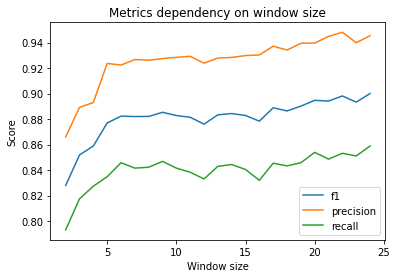

In [8]:
plt.plot(window_sizes, f1_scores, label='f1')
plt.plot(window_sizes, precision_scores, label='precision')
plt.plot(window_sizes, recall_scores, label='recall')
plt.title('Metrics dependency on window size')
plt.xlabel('Window size')
plt.ylabel('Score')
plt.legend()
plt.show()

In [9]:
def find_glove_token(x):
    res = []
    for w in x['tokens']:
        if w in glove.dictionary.keys():
            res.append(glove.dictionary[w])
        else:
            res.append(0)
    return res


f1_scores = []
precision_scores = []
recall_scores = []
window_size = 25
EMBEDDING_LENGTH = 10

for o_weight in tqdm(np.arange(0.05, 1.0000001, 0.05)):
    corpus = Corpus() 

    corpus.fit(df['tokens'], window=window_size)

    glove = Glove(no_components=EMBEDDING_LENGTH, learning_rate=0.05) 
    glove.fit(corpus.matrix, epochs=30, no_threads=8, verbose=False)
    glove.add_dictionary(corpus.dictionary)
    for d in all_dfs:
        d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
        d['int_tokens'] = d.apply(find_glove_token, axis=1)
    
    catboost_x_train = []
    catboost_y_train = []

    def prepare_data_for_catboost(x):
        tokenized_text = x['int_tokens']
        for i, token in enumerate(tokenized_text):
            catboost_x_train.append([])
            for shift in range(window_size):
                if i - window_size // 2 + shift < 0 or i - window_size // 2 + shift >= len(tokenized_text) :
                    catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
                else:
                    catboost_x_train[-1] += list(glove.word_vectors[tokenized_text[i - window_size // 2 + shift]])
            catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])

    train.apply(prepare_data_for_catboost, axis=1)

    catboost_x_test = []
    catboost_y_test = []

    def prepare_data_for_catboost(x):
        tokenized_text = x['int_tokens']
        for i, token in enumerate(tokenized_text):
            catboost_x_test.append([])
            for shift in range(window_size):
                if i - window_size // 2 + shift < 0 or i - window_size // 2 + shift >= len(tokenized_text) :
                    catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
                else:
                    catboost_x_test[-1] += list(glove.word_vectors[tokenized_text[i - window_size // 2 + shift]])
            catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])

    test.apply(prepare_data_for_catboost, axis=1)

    cb = CatBoostClassifier(verbose=False, task_type="GPU", class_weights=[1] * 2 + [o_weight], iterations=1000)
    cb.fit(catboost_x_train, catboost_y_train)
    pred = cb.predict(catboost_x_test)
    f1_scores.append(f1_score(catboost_y_test, pred, average='weighted', labels=[0, 1]))
    precision_scores.append(precision_score(catboost_y_test, pred, average='weighted', labels=[0, 1]))
    recall_scores.append(recall_score(catboost_y_test, pred, average='weighted', labels=[0, 1]))

100%|██████████| 20/20 [28:45<00:00, 86.27s/it]


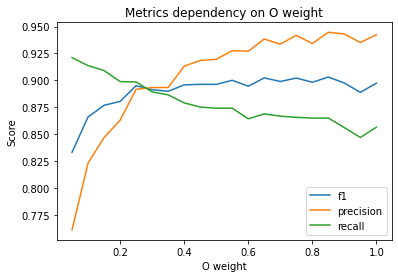

In [10]:
plt.plot(np.arange(0.05, 1.0000001, 0.05), f1_scores, label='f1')
plt.plot(np.arange(0.05, 1.0000001, 0.05), precision_scores, label='precision')
plt.plot(np.arange(0.05, 1.0000001, 0.05), recall_scores, label='recall')
plt.title('Metrics dependency on O weight')
plt.xlabel('O weight')
plt.ylabel('Score')
plt.legend()
plt.show()

## GLOVE (fixed, window=25, O_weight=0.7) + CatBoost

In [11]:
def find_glove_token(x):
    res = []
    for w in x['tokens']:
        if w in glove.dictionary.keys():
            res.append(glove.dictionary[w])
        else:
            res.append(0)
    return res

#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(df['tokens'], window=25)

glove = Glove(no_components=30, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=30, no_threads=8, verbose=False)
glove.add_dictionary(corpus.dictionary)

for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
    d['int_tokens'] = d.apply(find_glove_token, axis=1)

In [12]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 25
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])


train.apply(prepare_data_for_catboost, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
948    None
949    None
950    None
951    None
952    None
Length: 953, dtype: object

In [13]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 25
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
234    None
235    None
236    None
237    None
238    None
Length: 239, dtype: object

In [14]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", class_weights=[1, 1, 0.25], iterations=25000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [15]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

               precision    recall  f1-score   support

B-GoodsString     0.9288    0.9179    0.9234      1109
I-GoodsString     0.9115    0.8935    0.9024      1718

    micro avg     0.9183    0.9031    0.9106      2827
    macro avg     0.9202    0.9057    0.9129      2827
 weighted avg     0.9183    0.9031    0.9106      2827

